<a href="https://colab.research.google.com/github/prodramp/DeepWorks/blob/main/DL-SatelliteImagery/Satellite_Imagery_DeepLearning-LocalDiag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code from Part 1 Exercise - Satellite Imagery Data Preparation 



In [1]:
# !pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os
import cv2
from PIL import Image 
import numpy as np 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [2]:
minmaxscaler = MinMaxScaler()

In [3]:
dataset_root_folder = './'

In [4]:
dataset_name = "DubaiDataset/"

In [5]:
image_patch_size = 256

In [6]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [7]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [8]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


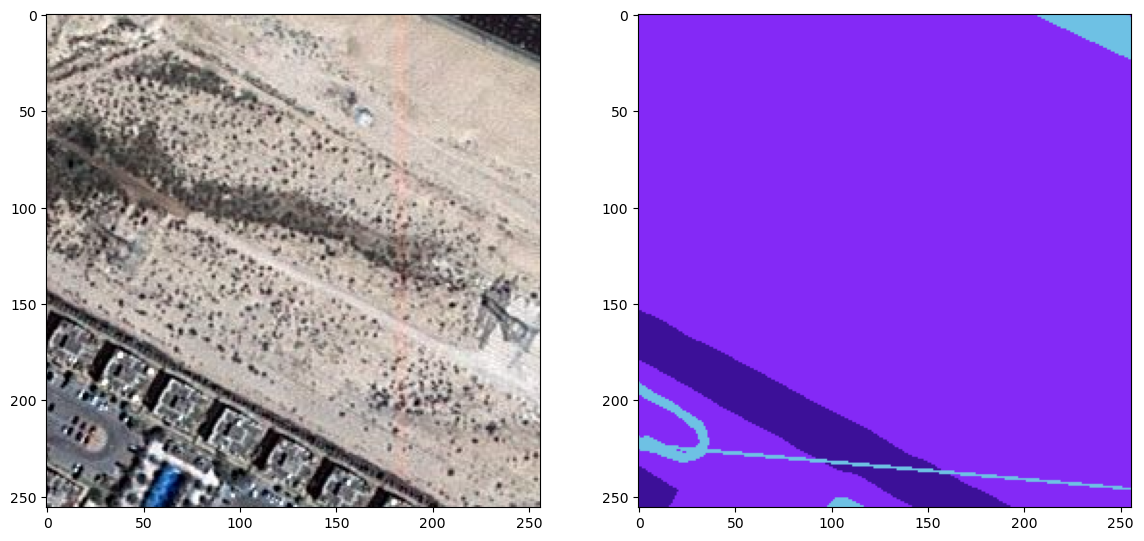

In [9]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [10]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [11]:
label = individual_patched_mask

In [12]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [13]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [14]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [15]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [16]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


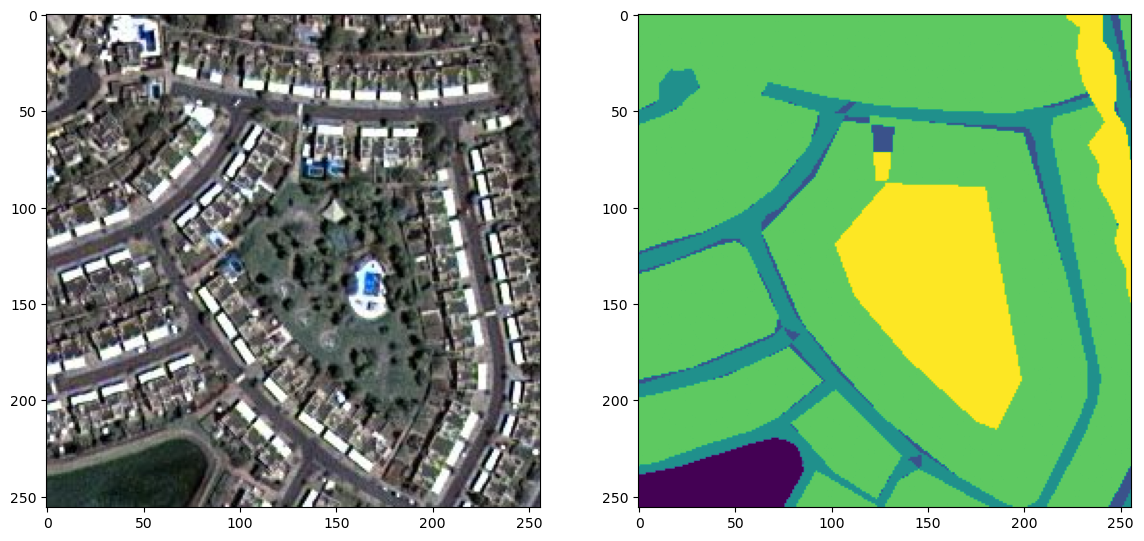

In [17]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [18]:
total_classes = len(np.unique(labels))

In [19]:
total_classes

6

In [20]:
from tensorflow.keras.utils import to_categorical 

In [21]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [22]:
master_trianing_dataset = image_dataset

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [26]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [27]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


# Coding for Part 2: Deep Learning with Satellite Imagery Data

In [29]:
# !pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [29]:
from keras import backend as K

In [30]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [31]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [32]:
metrics = ["accuracy", jaccard_coef]

In [33]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [34]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes, 
                          image_height=image_height, 
                          image_width=image_width, 
                          image_channels=image_channels)

In [35]:
model = get_deep_learning_model()

In [38]:
# Please uncomment this line to get model confiuration
# model.get_config()

## Generating Loss Function 

- dice loss > Focal Loss > Total Loss
- Total Loss = (Dice loss + (1*Focal Loss))

In [36]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [38]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [39]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [40]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [41]:
total_loss = dice_loss + (1 * focal_loss)

## Model compilation

In [42]:
import tensorflow as tf

In [43]:
tf.keras.backend.clear_session()


In [44]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

# Visualize Model with Keras

In [48]:
# from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model

In [49]:
plot_model(model, to_file="satellite_model_plot.png", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [50]:
import keras
from IPython.display import clear_output

%matplotlib inline

In [51]:
class PlotLoss(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.jaccard_coef = []
    self.val_jaccard_coef = []

    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)
    # self.losses.append(logs.get('loss'))
    # self.val_losses.append(logs.get('val_loss'))

    self.jaccard_coef.append(logs.get('jaccard_coef'))
    self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

    self.i += 1
    
    clear_output(wait=True)
    # plt.plot(self.x, self.losses, label="loss")
    # plt.plot(self.x, self.val_losses, label="val_loss")

    plt.plot(self.x, self.jaccard_coef, label="jaccard_coef")
    plt.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")

    plt.legend()
    plt.show()

plot_loss = PlotLoss()

In [52]:
class PlotLossEx(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []

    self.losses = []
    self.val_losses = []

    self.jaccard_coef = []
    self.val_jaccard_coef = []

    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)

    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    self.jaccard_coef.append(logs.get('jaccard_coef'))
    self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

    self.i += 1

    plt.figure(figsize=(14,8))
    f, (graph1, graph2) = plt.subplots(1,2, sharex=True)
    
    clear_output(wait=True)

    graph1.set_yscale('log')
    graph1.plot(self.x, self.losses, label="loss")
    graph1.plot(self.x, self.val_losses, label="val_loss")
    graph1.legend()

    graph2.set_yscale('log')
    graph2.plot(self.x, self.jaccard_coef, label="jaccard_coef")
    graph2.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")
    graph2.legend()

    plt.show();

plot_loss = PlotLossEx()

<Figure size 1400x800 with 0 Axes>

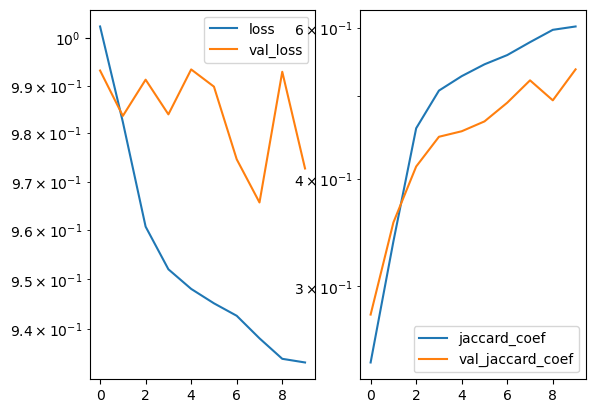

51/51 [==============================] - 313s 6s/step - loss: 0.9334 - accuracy: 0.7986 - jaccard_coef: 0.6018 - val_loss: 0.9727 - val_accuracy: 0.7184 - val_jaccard_coef: 0.5365


In [53]:
model_history = model.fit(X_train, y_train,
                        batch_size=16,
                        verbose=1,
                        epochs=10,
                        validation_data=(X_test, y_test),
                        callbacks=[plot_loss],
                        shuffle=False)

In [54]:
history_a = model_history

In [55]:
history_a.history

{'loss': [1.0025250911712646,
  0.9823549389839172,
  0.9607318043708801,
  0.9520562291145325,
  0.9480913281440735,
  0.9451895356178284,
  0.9426852464675903,
  0.9381757974624634,
  0.934095561504364,
  0.9333681464195251],
 'accuracy': [0.5383915901184082,
  0.680467426776886,
  0.7262101173400879,
  0.7468457818031311,
  0.7573063373565674,
  0.7642650008201599,
  0.7715584635734558,
  0.7835677266120911,
  0.7945415377616882,
  0.7986364960670471],
 'jaccard_coef': [0.2447829693555832,
  0.33846110105514526,
  0.45820894837379456,
  0.5068403482437134,
  0.5268281102180481,
  0.5437778830528259,
  0.5574285387992859,
  0.5770183801651001,
  0.5963869094848633,
  0.6017538905143738],
 'val_loss': [0.9931725263595581,
  0.9836323857307434,
  0.9912442564964294,
  0.9839556217193604,
  0.9934074282646179,
  0.9897761940956116,
  0.9745948910713196,
  0.9656865000724792,
  0.9929120540618896,
  0.9726904034614563],
 'val_accuracy': [0.6260480284690857,
  0.6326217651367188,
  0.6245

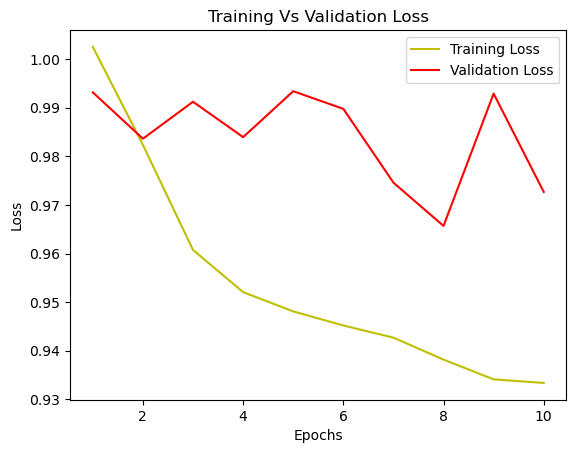

In [56]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

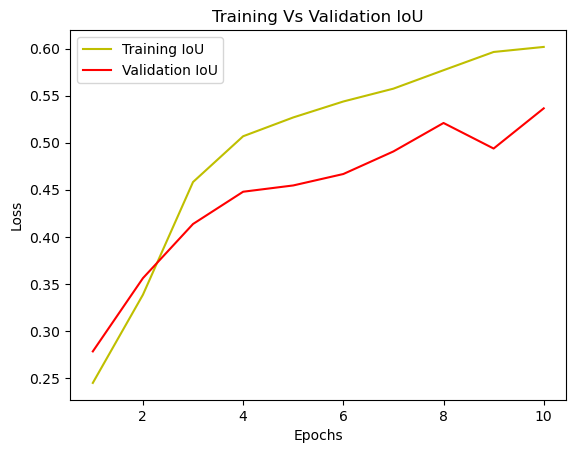

In [57]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [58]:
model_history.params

{'verbose': 1, 'epochs': 10, 'steps': 51}

In [59]:
y_pred = model.predict(X_test)

5/5 [==============================] - 10s 2s/step


In [60]:
len(y_pred)

142

In [61]:
y_pred

array([[[[1.00505777e-01, 3.65267158e-01, 2.34806418e-01,
          1.26306638e-01, 8.94556567e-02, 8.36583301e-02],
         [5.52614257e-02, 4.31751728e-01, 2.57718712e-01,
          1.15927979e-01, 7.98807219e-02, 5.94594665e-02],
         [8.55165571e-02, 3.48360002e-01, 2.53864616e-01,
          1.11334346e-01, 1.19824417e-01, 8.11000615e-02],
         ...,
         [9.87917110e-02, 2.27012455e-01, 2.15881601e-01,
          4.04331349e-02, 3.78060788e-01, 3.98203433e-02],
         [1.14235535e-01, 2.21251100e-01, 2.00492471e-01,
          4.24620695e-02, 3.74157250e-01, 4.74015623e-02],
         [1.43878669e-01, 2.02540621e-01, 1.88358724e-01,
          6.55238926e-02, 3.21320176e-01, 7.83778802e-02]],

        [[5.62238321e-02, 5.77213347e-01, 1.79629162e-01,
          8.36243182e-02, 6.84407577e-02, 3.48686278e-02],
         [3.12474910e-02, 6.76203430e-01, 1.62250087e-01,
          6.39846772e-02, 3.70907299e-02, 2.92235091e-02],
         [4.74526808e-02, 5.68431258e-01, 2.1948

In [62]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [63]:
len(y_pred_argmax)

142

In [64]:
y_pred_argmax

array([[[1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [4, 4, 4, ..., 2, 2, 2],
        [4, 4, 4, ..., 2, 2, 2],
        [4, 4, 4, ..., 2, 2, 4]],

       ...,

       [[4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [65]:
y_test_argmax = np.argmax(y_test, axis=3)

In [66]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

## Comparing prediction results
-  using test images using mask images and predicted result images..

In [67]:
import random


1/1 [==============================] - 0s 224ms/step


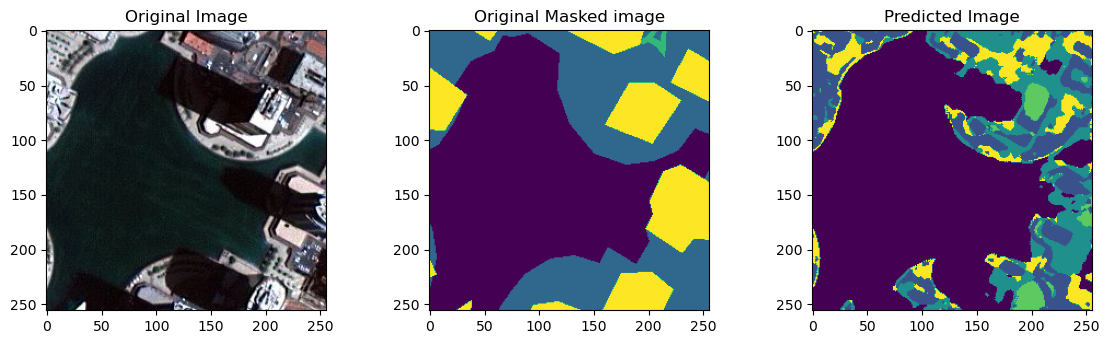

In [81]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [70]:
model.save("satellite_segmentation_full(2).h5")

C:\Users\dpsch\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [71]:
!dir

 Volume in drive E is Data
 Volume Serial Number is 7613-A0E0

 Directory of e:\Data_Science\Code\U-net Deep_works

06-05-2024  12:54 AM    <DIR>          .
06-05-2024  12:54 AM    <DIR>          ..
05-05-2024  10:35 PM                22 archive.zip
05-05-2024  10:35 PM    <DIR>          DubaiDataset
05-05-2024  11:53 PM         1,619,963 Satellite_Imagery_DeepLearning-Base.ipynb
05-05-2024  11:54 PM         1,755,908 Satellite_Imagery_DeepLearning-LocalDiag.ipynb
05-05-2024  10:44 PM         1,266,572 Satellite_Imagery_Segmentation.ipynb
06-05-2024  12:54 AM        23,508,584 satellite_segmentation_full(2).h5
05-05-2024  11:51 PM        23,508,584 satellite_segmentation_full.h5
               6 File(s)     51,659,633 bytes
               3 Dir(s)  240,425,345,024 bytes free
